<a href="https://colab.research.google.com/github/stef1927/dl-samples/blob/master/numpy-nn/numpy_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A feed forward neural network implemented only with numpy

In this notebook, a feed forward neural network is implemented using numpy and compared to a neural network implemented with pyTorch. The networks are used to predict daily bike rentals using the [bike sharing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip) from
Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", published in Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

The original version of this notebook can be found [here](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb). The modifications are mine with input from the first two chapters of this [book](http://neuralnetworksanddeeplearning.com/). 




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

This step downloads and unzips the dataset into a local folder, before loading it into a pandas data frame.

In [2]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
!unzip Bike-Sharing-Dataset.zip -d bike-sharing-dataset
!rm Bike-Sharing-Dataset.zip

data_path = 'bike-sharing-dataset/hour.csv'
rides = pd.read_csv(data_path)

--2022-01-22 20:57:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   979KB/s    in 0.3s    

2022-01-22 20:57:41 (979 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: bike-sharing-dataset/Readme.txt  
  inflating: bike-sharing-dataset/day.csv  
  inflating: bike-sharing-dataset/hour.csv  


In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Analysing the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. 

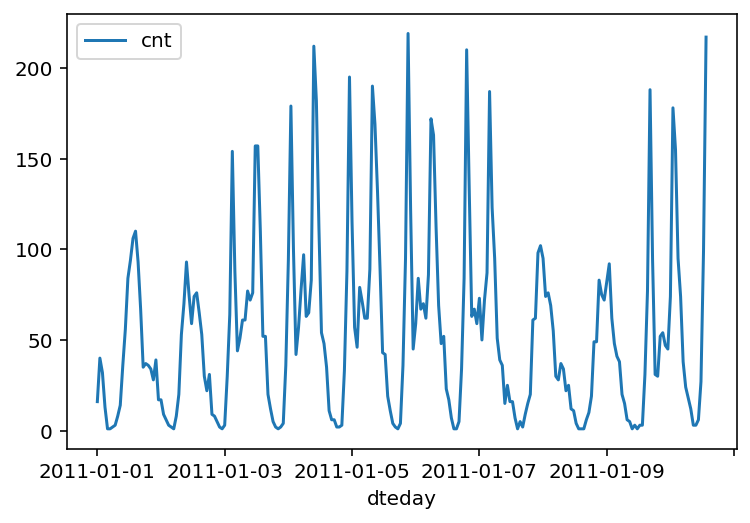

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Categorical variables
The categorical variables like season, weather and month need to be converted into binary variables, and this is done with Pandas `get_dummies()`.

In [5]:
categorical_variables = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in categorical_variables:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling quantitative variables
Quantitative values are scaled using the mean and standard deviation to make
training the network easier. 

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

quantitative_variables = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quantitative_variables:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

The data for the last approximately 21 days will be used as a test set after the network has been trained.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

The data is split into two sets, one for training and one for validating as the network is being trained. Since this is time series data, the network will train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## The numpy network

The network accepts an array for specifying the number of neurons in each layer, including the first and the last one, and uses the sigmoid function for activations between layers except for the last one, for which the activation function is $f(x)=x$ since this is a regression problem.
  

In [72]:
class NeuralNetwork(object):
    def __init__(self, nodes, learning_rate):
        """ 
        Save the parameters passed in, and initialize the weights. Parameters:
        nodes : a list containing the number of neurons for each layer
        learing_rate: the learning rate
        """
        self.num_layers = len(nodes) - 1
        self.nodes = nodes
        self.lr = learning_rate

        # Each layer is a (n_l x n_l - 1) matrix
        self.weights = []
        for i in range(self.num_layers):
          self.weights.append(np.random.normal(0.0, nodes[i] ** -0.5, (nodes[i], nodes[i+1])))
        
    # def run(self, features):
    #     """ Run a forward pass through the network with input features"""
    #     hidden_outputs = self.activation_function(np.dot(features, self.weights_input_to_hidden)) 
    #     return np.dot(hidden_outputs, self.weights_hidden_to_output)

    def run(self, x):
      for w in self.weights[:-1]:
        x = sigmoid(np.dot(x, w))

      return np.dot(x, self.weights[-1])

    def train(self, Xs, Ys):
      """
      For each record in the mini batch received, perform backprop, then update
      the weights when the entire mini batch has been processed.
      """

      num_records = Xs.shape[0]
      delta_weights = [np.zeros(w.shape) for w in self.weights]

      for x, y in zip(Xs, Ys):
        self.backprop(x, y, delta_weights)

      for i in range(self.num_layers):
        self.weights[i] += self.lr * delta_weights[i] / num_records

    def backprop(self, x, y, delta_weights):
      """
      Performs a forward and backward pass through the layers using the input and output
      sample passed in, returning the gradient of the cost with respect to the weights
      for each layer (nabla_w)
      """
     
      # hidden_outputs = self.activation_function(np.dot(X, self.weights_input_to_hidden))  
      # final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output)

      # forward pass
      activations = [x] # this list will store all the activations, or the inputs / outputs to and from layers
      zs = [] # this list stores the z vectors layer by layer, the linear combinations that are fed into the activation functions
      for i in range(self.num_layers):
        w = self.weights[i]
        z = np.dot(activations[-1], w)
        zs.append(z)
        if i < self.num_layers - 1:
          activations.append(sigmoid(z))
        else:
          activations.append(z)

      # error = y - final_outputs 
      # hidden_error = np.dot(error, self.weights_hidden_to_output.T)
      # output_error_term = error * 1
      # delta_weights_h_o += output_error_term * hidden_outputs[:, None]

      # hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
      # delta_weights_i_h += hidden_error_term * X[:, None]
      
      # backward pass, last layer
      error = y - activations[-1] # final error
      layer_grad = error * 1 # error times cost deriv (which is 1 since the activation funciton of the last layer is x itself)
      delta_weights[-1] += layer_grad * activations[-2][:, None]
      next_layer_error = np.dot(error, self.weights[-1].T) # contribution of the layer to the error

      # backward pass, other layers
      for l in range(2, self.num_layers+1):
        outputs = activations[-l]
        cost_deriv = outputs * (1 - outputs)
        layer_grad = next_layer_error * cost_deriv # layer error times cost deriv
        delta_weights[-l] += layer_grad * activations[-l-1][:, None]
        next_layer_error = np.dot(next_layer_error, self.weights[-l].T) # contribution of the layer to the error

##
## Some utility functions
## 

def sigmoid(z):
  """ The sigmoid function. """
  return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
  """ Derivative of the sigmoid function. """
  return sigmoid(z) * (1 - sigmoid(z))

def MSE(y, Y):
  """Calculate the Meand Squared Error. """
  #print("y={}, Y={}".format(y.shape, Y.shape))
  return np.mean((y-Y)**2)

## The PyTorch Network

This network should be equivalent to the one above implemented with numpy

## Training

The network is trained for a number of iterations after choosing the hyper parameters (learning rate and network shape). The train and validation losses
are calculated and stored so that they can be plotted later on.

In [78]:
import sys

###################
# Hyperparameters
###################
iterations = 1000
learning_rate = .75
hidden_nodes = 18
output_nodes = 1

N_i = train_features.shape[1]
#network = NeuralNetwork(nodes=[N_i, hidden_nodes, output_nodes], learning_rate=learning_rate)
network = NeuralNetwork(nodes=[N_i, hidden_nodes, hidden_nodes, output_nodes], learning_rate=learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
 
    network.train(X, y)
    
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.166 ... Validation loss: 0.292

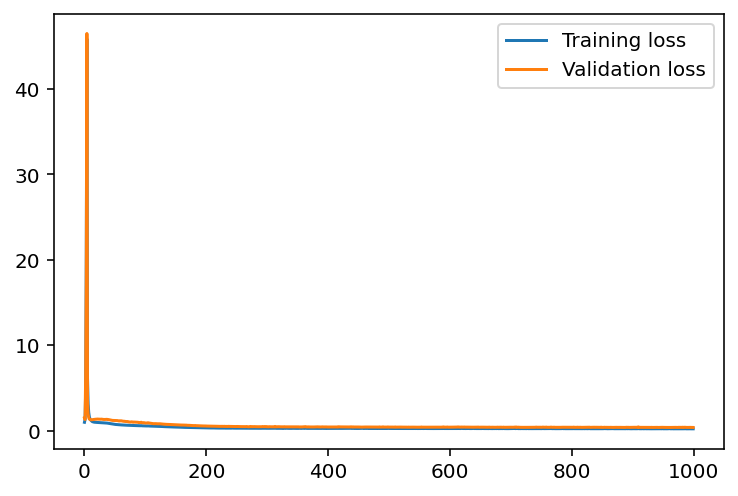

In [75]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check the predictions

Use the test data to view how well the network is modeling the data. 

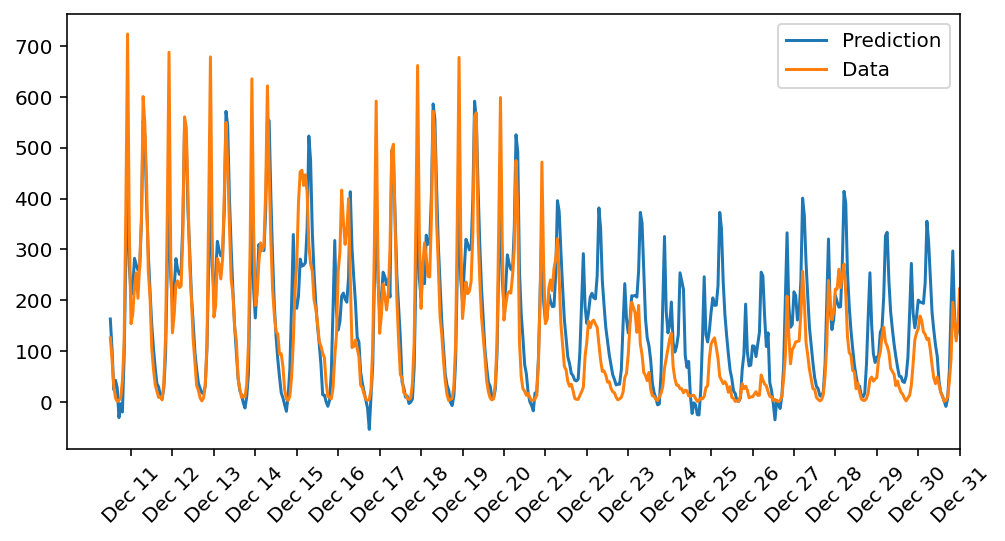

In [77]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
#print(predictions.shape)
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)